In [2]:
import pandas as pd
import numpy as np

# Reading benchmark results

In [3]:
MD = 3

# data = pd.read_table("../data/results_icml_revision/classification_nn_single_curvature_128dim.tsv")
# data = pd.read_table(f"../data/results_icml_revision/classification_nn_single_curvature_1024dim_usespecialdims_md{MD}_8clusters.tsv")
data = pd.read_table(
    # f"../data/results_icml_revision/classification_nn_single_curvature_1024dim_usespecialdims_md{MD}_8clusters_full_FINAL.tsv"
    "../data/results_icml_revision/classification_nn_single_curvature_1024dim_usespecialdims_md3_8clusters_FINAL.tsv"
)
data

,dataset,signature,seed,product_rf_f1-micro,single_manifold_rf_f1-micro,sklearn_rf_f1-micro,tangent_rf_f1-micro,product_rf_f1-macro,single_manifold_rf_f1-macro,sklearn_rf_f1-macro,tangent_rf_f1-macro,product_rf_accuracy,single_manifold_rf_accuracy,sklearn_rf_accuracy,tangent_rf_accuracy,product_rf_time,single_manifold_rf_time,sklearn_rf_time,tangent_rf_time
0,gaussian,H1024,1,0.975,0.960,0.970,0.935,0.855795,0.920319,0.852621,0.793921,0.975,0.960,0.970,0.935,0.300320,1.489374,0.045059,0.044631
1,gaussian,H1024,2,0.940,0.915,0.975,0.875,0.824794,0.838816,0.900380,0.731701,0.940,0.915,0.975,0.875,0.261761,1.569777,0.044462,0.043863
2,gaussian,H1024,3,0.970,0.940,0.950,0.965,0.702870,0.750152,0.670055,0.693883,0.970,0.940,0.950,0.965,0.286736,1.560318,0.042280,0.043363
3,gaussian,H1024,4,0.945,0.910,0.945,0.940,0.628358,0.698538,0.599076,0.638856,0.945,0.910,0.945,0.940,0.270473,1.298335,0.043905,0.043383
4,gaussian,H1024,5,0.925,0.935,0.930,0.920,0.638113,0.891887,0.673372,0.599071,0.925,0.935,0.930,0.920,0.264836,1.566504,0.046023,0.044233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,gaussian,HS4,596,0.575,0.340,0.620,0.640,0.511268,0.322139,0.534430,0.600908,0.575,0.340,0.620,0.640,0.117458,3.869236,0.031929,0.032388
596,gaussian,HS4,597,0.615,0.505,0.620,0.680,0.366160,0.347478,0.388587,0.438442,0.615,0.505,0.620,0.680,0.111390,3.450865,0.032520,0.031872
597,gaussian,HS4,598,0.540,0.505,0.590,0.585,0.395783,0.472842,0.491834,0.476241,0.540,0.505,0.590,0.585,0.116169,4.238420,0.032413,0.032555
598,gaussian,HS4,599,0.590,0.670,0.590,0.650,0.485812,0.636671,0.458729,0.553239,0.590,0.670,0.590,0.650,0.113812,3.561875,0.031739,0.031906


In [8]:
# from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

VAL = "accuracy"

order = [
    "H4",
    "S4",
    "HH4",
    "SS4",
    "HS4",
    "H16",
    "S16",
    "HH16",
    "SS16",
    "HS16",
    "H64",
    "S64",
    "HH64",
    "SS64",
    "HS64",
    "H1024",
    "S1024",
    "HH1024",
    "SS1024",
    "HS1024",
]


def aggfunc(group):
    """Calculate mean and 95% confidence interval for each accuracy column."""
    result = {}
    for col in group.columns:
        if col == "signature":
            continue
        # Get 95% CI on percentages
        values = group[col].values
        mean = np.mean(values)
        ci = 1.96 * np.std(values) / np.sqrt(len(values))
        mean, ci = mean * 100, ci * 100
        result[col] = f"{mean:.2f} ± {ci:.2f}"

        # Add t-test p-value if comparing product_rf vs sklearn_rf
        if f"product_rf_{VAL}" in col and f"sklearn_rf_{VAL}" in group.columns:
            try:
                p_val = wilcoxon(group[f"product_rf_{VAL}"].values, group[f"sklearn_rf_{VAL}"].values)[1]
                result[f"p_value: product_rf vs sklearn_rf"] = f"{p_val:.4f}"
            except:
                result[f"p_value: product_rf vs sklearn_rf"] = "N/A"
        if f"product_rf_{VAL}" in col and f"tangent_rf_{VAL}" in group.columns:
            try:
                p_val = wilcoxon(group[f"product_rf_{VAL}"].values, group[f"tangent_rf_{VAL}"].values)[1]
                result[f"p_value: product_rf vs tangent_rf"] = f"{p_val:.4f}"
            except:
                result[f"p_value: product_rf vs tangent_rf"] = "N/A"
                
    return pd.Series(result)


def stylefunc(x):
    """Highlight the maximum value in each row."""
    is_max = pd.Series(data=False, index=x.index)
    # Filter out empty strings before finding max
    valid_values = x[x != ""]
    if not valid_values.empty:
        means = valid_values.str.split("±").str[0].astype(float)
        if not means.empty:
            is_max[means.idxmax()] = True
    return ["background-color: lightgreen" if v else "" for v in is_max]


# Filter columns to only include accuracy metrics and signature
data_filtered = data[[c for c in data.columns if VAL in c or c == "signature"]]

# Group by signature and apply aggregation function
data_agg = data_filtered.groupby("signature").apply(aggfunc)

# Reorder according to specified order
# data_sorted = data_agg.reindex(order)[["product_rf_accuracy", "sklearn_rf_accuracy", "p_value"]]
data_sorted = data_agg.reindex(order)[
    # ["product_rf_accuracy", "sklearn_rf_accuracy", "single_manifold_rf_accuracy", "tangent_rf_accuracy", "p_value: product_rf vs sklearn_rf", "p_value: product_rf vs tangent_rf"]
    ["product_rf_accuracy", "sklearn_rf_accuracy", "p_value: product_rf vs sklearn_rf"]
]

# # Single manifold rf should not be assessed for any single-manifold signatures
# for sign in ["H4", "S4", "H16", "S16", "H64", "S64", "H1024", "S1024"]:
#     data_sorted.loc[sign, "single_manifold_rf_accuracy"] = ""

# Apply styling and display
styled = data_sorted.style.apply(stylefunc, axis=1)

styled

/tmp/ipykernel_161379/3499337602.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_agg = data_filtered.groupby("signature").apply(aggfunc)


,product_rf_accuracy,sklearn_rf_accuracy,p_value: product_rf vs sklearn_rf
signature,,,
H4,81.73 ± 1.64,79.25 ± 1.33,0.0078
S4,64.38 ± 1.42,61.18 ± 1.13,0.0001
HH4,69.27 ± 1.98,68.15 ± 1.87,0.1191
SS4,41.05 ± 2.27,40.45 ± 2.08,0.3330
HS4,60.37 ± 1.89,60.17 ± 1.66,0.7323
H16,92.02 ± 1.12,90.60 ± 1.08,0.0046
S16,52.58 ± 1.68,46.28 ± 1.55,0.0000
HH16,81.45 ± 1.41,80.52 ± 1.44,0.1469
SS16,66.52 ± 1.53,64.90 ± 1.73,0.0441


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'styled' is your dataframe with highlighting already applied
# Create figure with appropriate dimensions based on the table size
plt.figure(figsize=(16, 12))
ax = plt.subplot(111, frame_on=False)

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Create the table
table = ax.table(
    cellText=data_sorted.values,
    rowLabels=data_sorted.index,
    colLabels=data_sorted.columns,
    cellLoc="center",
    loc="center",
    bbox=[0, 0, 1, 1]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)

# Apply the highlighting (using the same green color from the image)
for i in range(len(data_sorted.index)):
    for j in range(len(data_sorted.columns)):
        cell = table[(i + 1, j)]
        # Check if the cell value is highlighted in your styled dataframe
        # For a real implementation, you'd need to extract this information from 'styled'
        # This is a placeholder for that logic
        if pd.notna(data_sorted.iloc[i, j]) and data_sorted.iloc[i, j] != '':
            # Get background color from the styled dataframe
            # In a real implementation, you'd need to detect which cells are highlighted
            # Here, we just check if the cell is already highlighted in the styled dataframe
            if '±' in str(data_sorted.iloc[i, j]):
                # Parse the cell value to get the numeric part
                value = float(str(data_sorted.iloc[i, j]).split('±')[0].strip())
                
                # Columns where we need to check maximum values (accuracy columns)
                is_accuracy_col = any(name in data_sorted.columns[j] for name in ['accuracy'])
                
                # Get values from the same row for comparison
                row_values = [float(str(v).split('±')[0].strip()) if '±' in str(v) else 0 
                             for v in data_sorted.iloc[i, :4] if pd.notna(v) and v != '']
                
                # Check if this is the maximum value in its row (for accuracy columns)
                if is_accuracy_col and value == max(row_values):
                    cell.set_facecolor("lightgreen")

# Save the figure
plt.title("Model Comparison by Signature")
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
plt.close()

# `max_depth` benchmarks

In [1]:
# import manify
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# import warnings
# from tqdm.notebook import tqdm
# from sklearn.metrics import accuracy_score

# # params
# # DIMS = [4, 8]
# # SIGS = ["H", "S", "HH", "SS", "HS"]
# # MAX_DEPTH = 5
# # TRIALS = 1
# DIMS = [1024, 256, 128, 64, 16, 4]
# SIGS = ["H", "S", "HH", "SS", "HS"]
# MAX_DEPTH = 20
# TRIALS = 10

# warnings.filterwarnings("ignore", category=UserWarning)  # Gaussian mixture warnings

# rf_kwargs = {"n_estimators": 12, "min_samples_leaf": 1, "min_samples_split": 2}

# sig_dict = {
#     "H": [(-1, 4)],
#     "S": [(1, 4)],
#     "HH": [(-1, 2), (-1, 2)],
#     "SS": [(1, 2), (1, 2)],
#     "HS": [(-1, 2), (1, 2)],
# }

# my_tqdm = tqdm(total=(MAX_DEPTH - 1) * TRIALS * len(SIGS) * len(DIMS))
# results = []
# seed = 0
# for dim in DIMS:
#     for signature in SIGS:
#         sig = [(K, int(d * dim / 4)) for K, d in sig_dict[signature]]
#         pm = manify.manifolds.ProductManifold(sig)
#         for trial in range(TRIALS):
#             X, y = pm.gaussian_mixture(
#                 1000, num_classes=8, num_clusters=8, cov_scale_means=1 / dim, cov_scale_points=1 / dim
#             )
#             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)
#             for max_depth in range(1, MAX_DEPTH):
#                 rf_kwargs["max_depth"] = max_depth
#                 product_rf = manify.predictors.tree_icml.ProductSpaceRF(
#                     pm=pm, **rf_kwargs, n_features="d", use_special_dims=True, random_state=seed
#                 )
#                 product_rf.fit(X_train.to("cuda"), y_train.to("cuda"))
#                 product_rf_accuracy = accuracy_score(y_test, product_rf.predict(X_test.to("cuda")).cpu().numpy())

#                 sklearn_rf = RandomForestClassifier(**rf_kwargs, random_state=seed)
#                 sklearn_rf.fit(X_train, y_train)
#                 sklearn_rf_accuracy = accuracy_score(y_test, sklearn_rf.predict(X_test))

#                 X_train_tangent, X_test_tangent = (
#                     pm.logmap(X_train).detach().numpy(),
#                     pm.logmap(X_test).detach().numpy(),
#                 )
#                 tangent_rf = RandomForestClassifier(**rf_kwargs, random_state=seed)
#                 tangent_rf.fit(X_train_tangent, y_train)
#                 tangent_rf_accuracy = accuracy_score(y_test, tangent_rf.predict(X_test_tangent))

#                 ensemble = manify.predictors.tree_icml.SingleManifoldEnsembleRF(
#                     pm, n_features="d", use_special_dims=True, **rf_kwargs
#                 )
#                 ensemble.fit(X_train.to("cuda"), y_train.to("cuda"))
#                 ensemble_accuracy = accuracy_score(y_test, ensemble.predict(X_test.to("cuda")).cpu().numpy())

#                 results.append(
#                     {
#                         "dim": dim,
#                         "signature": signature,
#                         "max_depth": max_depth,
#                         "trial": trial,
#                         "product_rf_accuracy": product_rf_accuracy,
#                         "sklearn_rf_accuracy": sklearn_rf_accuracy,
#                         "tangent_rf_accuracy": tangent_rf_accuracy,
#                         "ensemble_accuracy": ensemble_accuracy,
#                     }
#                 )

#                 my_tqdm.update(1)
#                 my_tqdm.set_postfix(
#                     dim=dim,
#                     signature=signature,
#                     max_depth=max_depth,
#                     trial=trial,
#                     product_rf_accuracy=product_rf_accuracy,
#                     sklearn_rf_accuracy=sklearn_rf_accuracy,
#                     tangent_rf_accuracy=tangent_rf_accuracy,
#                     ensemble_accuracy=ensemble_accuracy,
#                 )
#             seed += 1  # Only update seed once per trial, to keep the curves monotonic-ish

# results = pd.DataFrame(results)

# results.to_csv("../data/results_icml_revision/max_depth_vs_accuracy.csv", index=False)

# # results.groupby("max_depth").mean()

import pandas as pd

DIMS = [1024, 256, 128, 64, 16, 4]
SIGS = ["H", "S", "HH", "SS", "HS"]
MAX_DEPTH = 20
TRIALS = 10

results = pd.read_csv("../data/results_icml_revision/max_depth_vs_accuracy.csv")

In [3]:
# Drop all max_depths > 10
results = results[results["max_depth"] <= 10]

/tmp/ipykernel_162947/903816540.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = results[results["dim"] == dim][results["signature"] == signature].drop(
/tmp/ipykernel_162947/903816540.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = results[results["dim"] == dim][results["signature"] == signature].drop(
/tmp/ipykernel_162947/903816540.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = results[results["dim"] == dim][results["signature"] == signature].drop(
/tmp/ipykernel_162947/903816540.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = results[results["dim"] == dim][results["signature"] == signature].drop(
/tmp/ipykernel_162947/903816540.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = results[results["dim"] == dim][results["signature"] == si

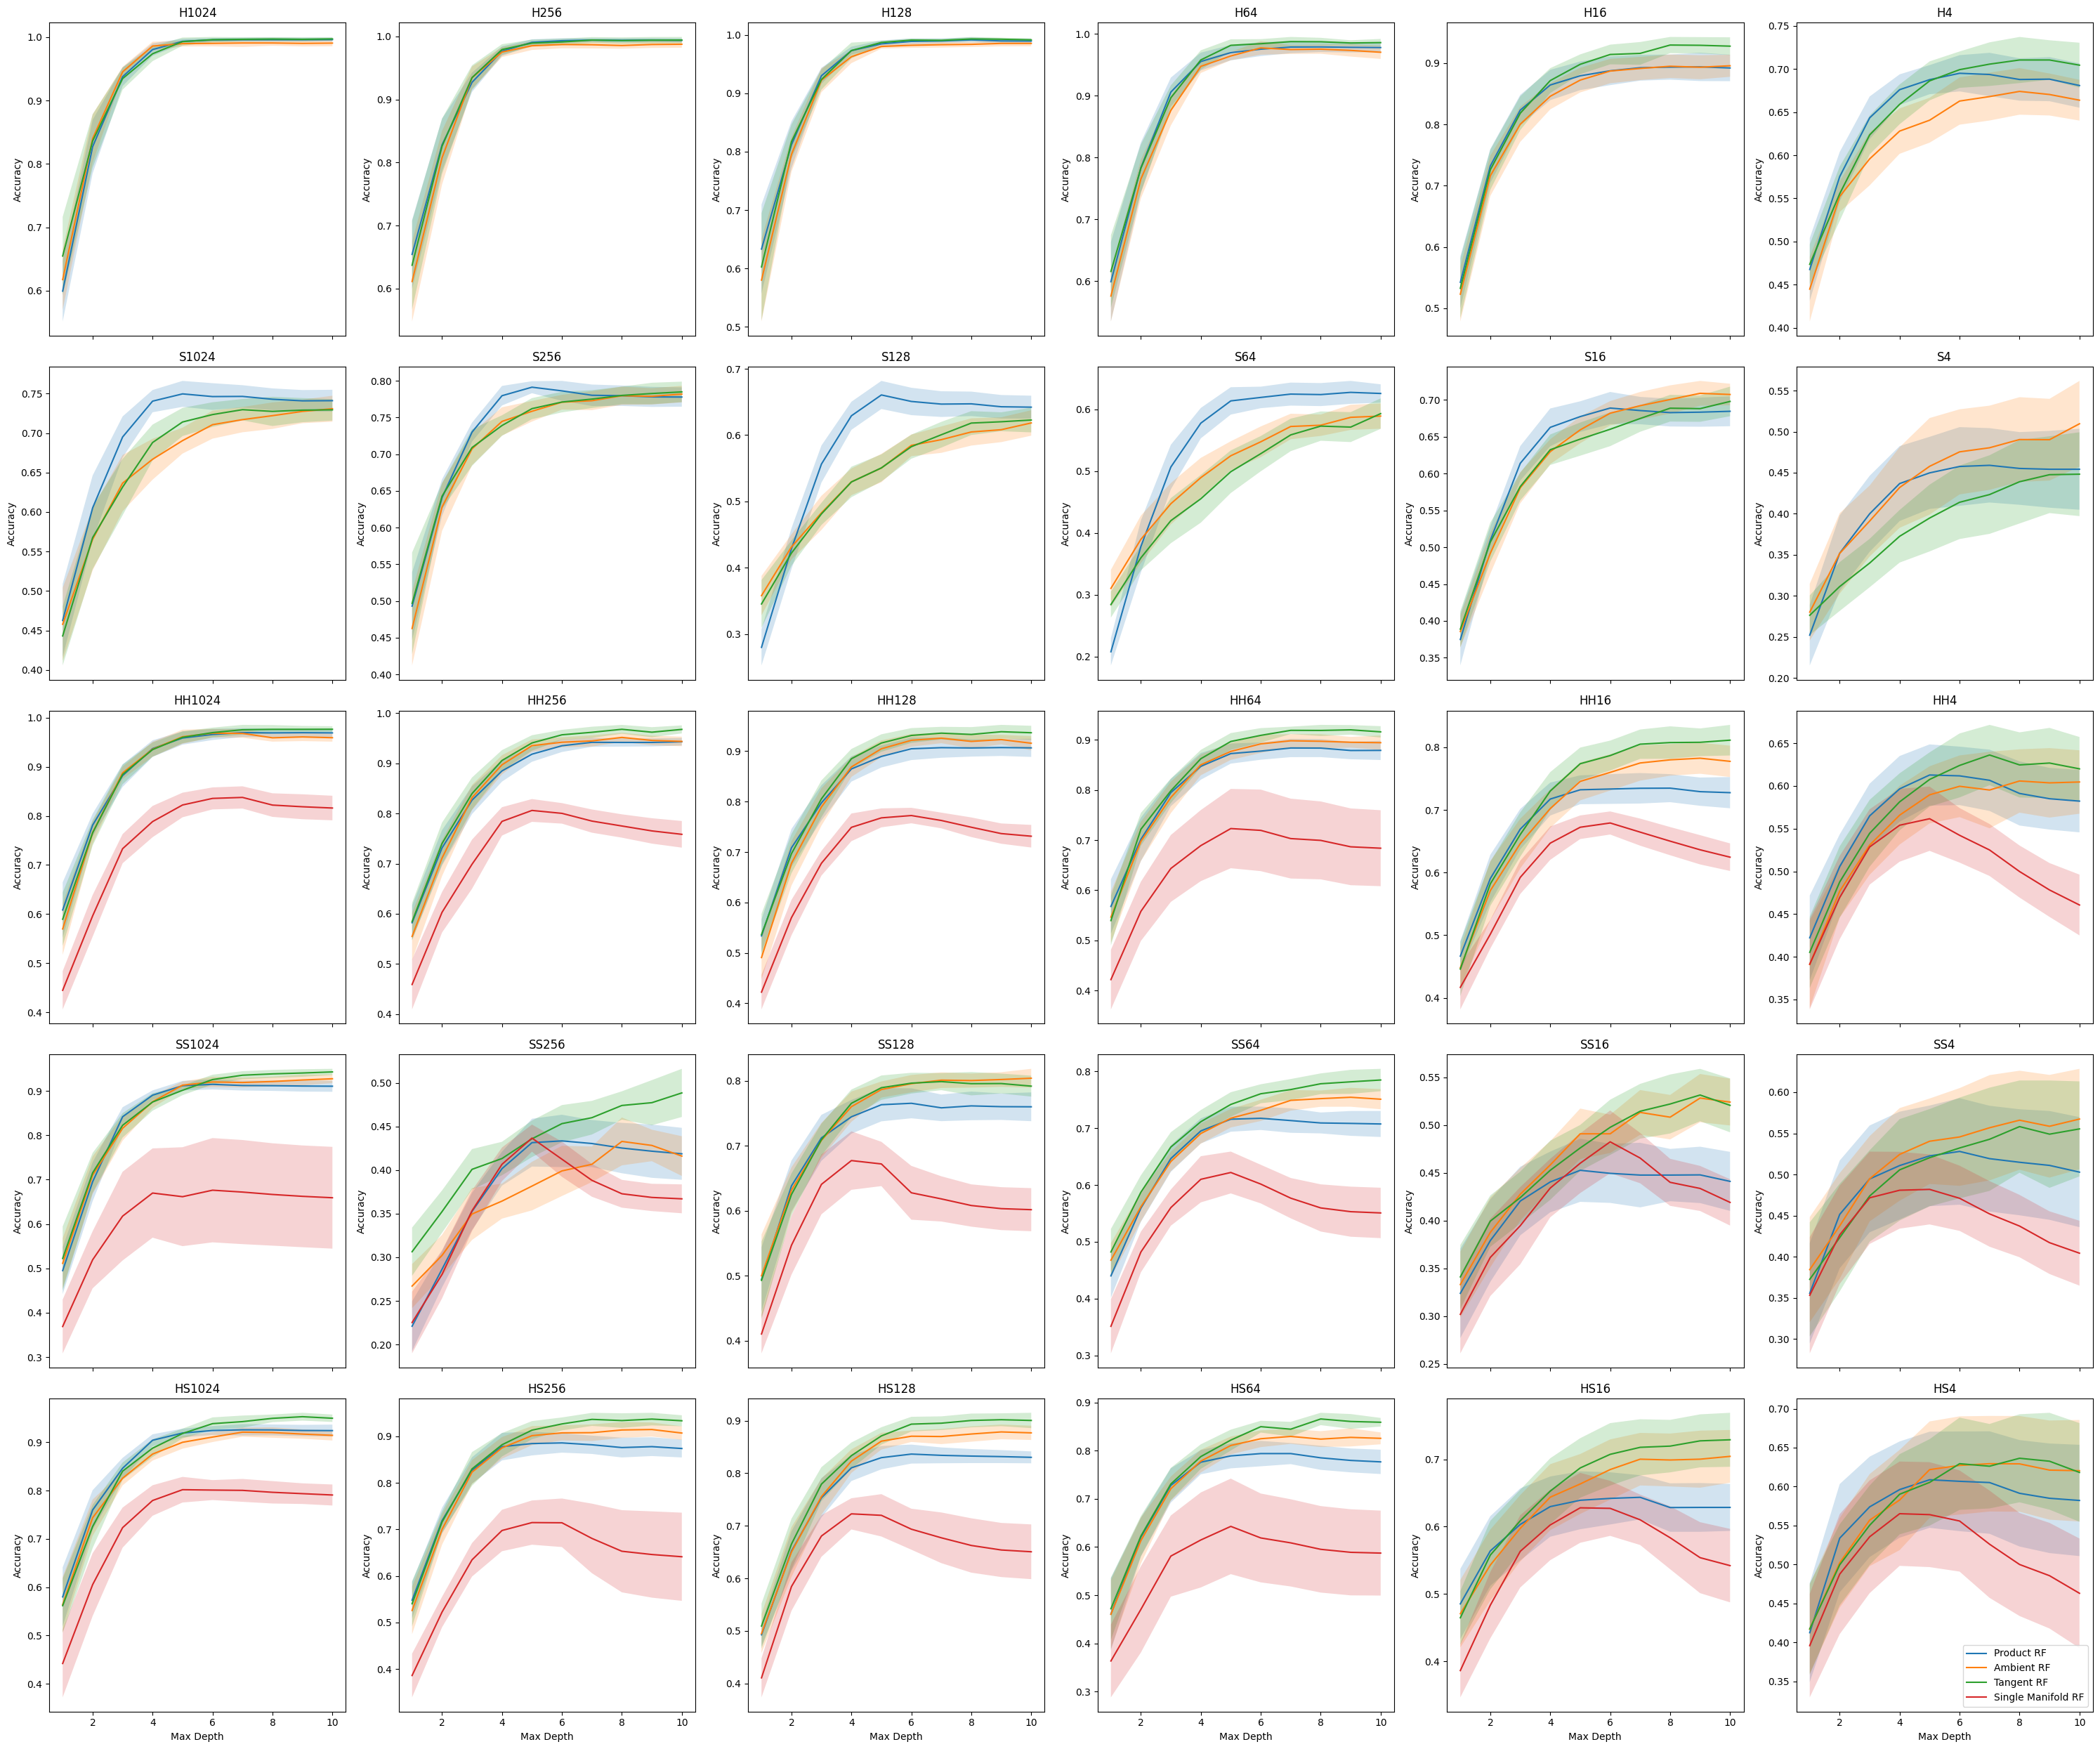

In [5]:
# Aggregate results
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(len(SIGS), len(DIMS), figsize=(5 * len(DIMS), 5 * len(SIGS)), sharex=True)

for dim in DIMS:
    for signature in SIGS:
        ax = axs[SIGS.index(signature), DIMS.index(dim)]
        df_filtered = results[results["dim"] == dim][results["signature"] == signature].drop(
            columns=["dim", "signature"]
        )
        means = df_filtered.groupby("max_depth").mean()
        cis = df_filtered.groupby("max_depth").apply(lambda x: 1.96 * x.std() / np.sqrt(len(x)), include_groups=False)

        ax.plot(means.index, means["product_rf_accuracy"], label="Product RF")
        ax.fill_between(
            means.index,
            means["product_rf_accuracy"] - cis["product_rf_accuracy"],
            means["product_rf_accuracy"] + cis["product_rf_accuracy"],
            alpha=0.2,
        )
        ax.plot(means.index, means["sklearn_rf_accuracy"], label="Ambient RF")
        ax.fill_between(
            means.index,
            means["sklearn_rf_accuracy"] - cis["sklearn_rf_accuracy"],
            means["sklearn_rf_accuracy"] + cis["sklearn_rf_accuracy"],
            alpha=0.2,
        )
        ax.plot(means.index, means["tangent_rf_accuracy"], label="Tangent RF")
        ax.fill_between(
            means.index,
            means["tangent_rf_accuracy"] - cis["tangent_rf_accuracy"],
            means["tangent_rf_accuracy"] + cis["tangent_rf_accuracy"],
            alpha=0.2,
        )
        if signature in ["HH", "SS", "HS"]:
            ax.plot(means.index, means["ensemble_accuracy"], label="Single Manifold RF")
            ax.fill_between(
                means.index,
                means["ensemble_accuracy"] - cis["ensemble_accuracy"],
                means["ensemble_accuracy"] + cis["ensemble_accuracy"],
                alpha=0.2,
            )
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{signature}{dim}")
        # ax.set_xscale("log")

axs[-1][-1].legend(loc="lower right")
# axs[-1].set_xlabel("Max Depth")
for ax in axs[-1]:
    ax.set_xlabel("Max Depth")

plt.tight_layout()
# plt.show()
plt.savefig("max_depth_vs_accuracy.png", dpi=300)

# Independently picking params

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import manify
import torch
import random
from collections import defaultdict
from scipy import stats
from tqdm.auto import tqdm

# Define signature and dimension
dim = 12
signature = [(-1, 4), (0, 4), (1, 4)]
pm = manify.manifolds.ProductManifold(signature=signature)


# Function to generate new data
def generate_data(dim, pm, random_state):
    n_samples = 1000
    num_classes = 8
    num_clusters = 8
    X, y = pm.gaussian_mixture(
        n_samples,
        num_classes=num_classes,
        num_clusters=num_clusters,
        cov_scale_means=1 / dim,
        cov_scale_points=1 / dim,
        seed=random_state,
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    X_train_tangent = pm.logmap(X_train).detach().cpu().numpy()
    X_test_tangent = pm.logmap(X_test).detach().cpu().numpy()

    return X_train, X_test, y_train, y_test, X_train_tangent, X_test_tangent


# Define hyperparameter space
param_space = {
    "n_estimators": [3, 6, 12, 24],
    "min_samples_split": [2, 4, 8, 16, 32],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "max_depth": [1, 3, 5, 7, 9, None],
    "max_features": ["sqrt", "log2", None],
    "n_features": ["d", "d_choose_2"],
    "use_special_dims": [True, False],
}

# Model definitions
models = {
    "ProductSpaceRF": {
        "class": manify.predictors.tree_icml.ProductSpaceRF,
        "params": [
            "n_estimators",
            "min_samples_split",
            "min_samples_leaf",
            "max_depth",
            "max_features",
            "n_features",
            "use_special_dims",
        ],
        "requires_pm": True,
        "cuda": True,
    },
    "SklearnRF": {
        "class": RandomForestClassifier,
        "params": ["n_estimators", "min_samples_split", "min_samples_leaf", "max_depth", "max_features"],
        "requires_pm": False,
        "cuda": False,
    },
    "TangentRF": {
        "class": RandomForestClassifier,
        "params": ["n_estimators", "min_samples_split", "min_samples_leaf", "max_depth", "max_features"],
        "requires_pm": False,
        "cuda": False,
        "use_tangent": True,
    },
    "SingleManifoldEnsembleRF": {
        "class": manify.predictors.tree_icml.SingleManifoldEnsembleRF,
        "params": [
            "n_estimators",
            "min_samples_split",
            "min_samples_leaf",
            "max_depth",
            "n_features",
            "use_special_dims",
        ],
        "requires_pm": True,
        "cuda": True,
    },
}


# Hyperparameter tuning function
def tune_hyperparameters(n_datasets=10, n_param_sets=30, n_folds=5, random_seed=42):
    # Pre-generate all datasets
    print("Generating datasets...")
    all_datasets = []
    for dataset_idx in tqdm(range(n_datasets), desc="Generating datasets"):
        dataset_seed = random_seed + dataset_idx
        dataset = generate_data(dim, pm, dataset_seed)
        all_datasets.append((dataset_seed, dataset))

    # Generate parameter combinations
    print("Generating parameter combinations...")
    param_combinations = []
    for _ in range(n_param_sets):
        params = {}
        for param_name, param_values in param_space.items():
            params[param_name] = random.choice(param_values)
        param_combinations.append(params)

    # Dictionary to store results by model, param set, and dataset
    results = defaultdict(lambda: defaultdict(dict))

    # Track total progress
    total_steps = len(models) * n_param_sets * n_datasets * n_folds
    progress_bar = tqdm(total=total_steps, desc="Hyperparameter tuning")

    # Evaluate each model
    for model_name, model_config in models.items():
        print(f"\n===== Evaluating {model_name} =====")

        # Evaluate each parameter combination
        for param_idx, full_params in enumerate(param_combinations):
            # Filter parameters for this model
            model_params = {k: v for k, v in full_params.items() if k in model_config["params"]}

            # Store scores for this param set across all datasets
            dataset_scores = []

            # Evaluate on all datasets
            for dataset_idx, (dataset_seed, dataset) in enumerate(all_datasets):
                X_train, X_test, y_train, y_test, X_train_tangent, X_test_tangent = dataset

                # Cross-validation splits
                kf = KFold(n_splits=n_folds, shuffle=True, random_state=dataset_seed)
                cv_splits = list(kf.split(X_train))

                # Evaluate params on cross-validation
                fold_scores = []
                for train_idx, val_idx in cv_splits:
                    # Prepare data for this fold
                    X_fold_train = X_train[train_idx]
                    y_fold_train = y_train[train_idx]
                    X_fold_val = X_train[val_idx]
                    y_fold_val = y_train[val_idx]

                    if model_config.get("use_tangent", False):
                        X_fold_train = X_train_tangent[train_idx]
                        X_fold_val = X_train_tangent[val_idx]

                    # Initialize model
                    if model_config["requires_pm"]:
                        model = model_config["class"](pm=pm, random_state=dataset_seed, **model_params)
                    else:
                        model = model_config["class"](random_state=dataset_seed, **model_params)

                    # Train model
                    if model_config["cuda"]:
                        model.fit(X_fold_train.to("cuda"), y_fold_train.to("cuda"))
                        y_pred = model.predict(X_fold_val.to("cuda")).cpu().numpy()
                    else:
                        model.fit(X_fold_train, y_fold_train)
                        y_pred = model.predict(X_fold_val)

                    # Calculate score
                    score = accuracy_score(y_fold_val, y_pred)
                    fold_scores.append(score)

                    # Update progress
                    progress_bar.update(1)

                # Store cross-validation result
                cv_score = np.mean(fold_scores)
                dataset_scores.append(
                    {
                        "dataset_idx": dataset_idx,
                        "dataset_seed": dataset_seed,
                        "cv_score": cv_score,
                        "fold_scores": fold_scores,
                    }
                )

            # Calculate average score across all datasets
            if dataset_scores:
                avg_cv_score = np.mean([ds["cv_score"] for ds in dataset_scores])
                results[model_name][param_idx] = {
                    "params": model_params,
                    "avg_cv_score": avg_cv_score,
                    "dataset_scores": dataset_scores,
                }

                # Display progress information
                param_str = ", ".join([f"{k}={v}" for k, v in model_params.items()])
                print(f"  Param set {param_idx+1}/{n_param_sets} ({param_str}): Avg CV Score = {avg_cv_score:.4f}")

    progress_bar.close()

    # Find best parameter set for each model and evaluate on test sets
    print("\nFinding best parameter set for each model and evaluating on test sets...")
    final_results = {}

    for model_name, param_results in results.items():
        print(f"\n===== Best parameters for {model_name} =====")

        # Find parameter set with highest average CV score
        best_param_idx = max(param_results.keys(), key=lambda idx: param_results[idx]["avg_cv_score"])
        best_params = param_results[best_param_idx]["params"]
        best_cv_score = param_results[best_param_idx]["avg_cv_score"]

        # Print best parameters
        print(f"Best CV score: {best_cv_score:.4f}")
        for param, value in best_params.items():
            print(f"  {param}: {value}")

        # Evaluate on test sets
        test_scores = []
        for dataset_idx, (dataset_seed, dataset) in enumerate(all_datasets):
            X_train, X_test, y_train, y_test, X_train_tangent, X_test_tangent = dataset

            # Train with best parameters
            if models[model_name]["requires_pm"]:
                model = models[model_name]["class"](pm=pm, random_state=dataset_seed, **best_params)
            else:
                model = models[model_name]["class"](random_state=dataset_seed, **best_params)

            # Train and evaluate
            if models[model_name]["cuda"]:
                model.fit(X_train.to("cuda"), y_train.to("cuda"))
                test_pred = model.predict(X_test.to("cuda")).cpu().numpy()
            elif models[model_name].get("use_tangent", False):
                model.fit(X_train_tangent, y_train)
                test_pred = model.predict(X_test_tangent)
            else:
                model.fit(X_train, y_train)
                test_pred = model.predict(X_test)

            # Calculate score
            test_score = accuracy_score(y_test, test_pred)
            test_scores.append({"dataset_idx": dataset_idx, "dataset_seed": dataset_seed, "test_score": test_score})

            print(f"  Dataset {dataset_idx+1}: Test score = {test_score:.4f}")

        # Calculate average test score
        avg_test_score = np.mean([ts["test_score"] for ts in test_scores])
        print(f"Average test score: {avg_test_score:.4f}")

        # Store final results
        final_results[model_name] = {
            "best_params": best_params,
            "avg_cv_score": best_cv_score,
            "avg_test_score": avg_test_score,
            "test_scores": test_scores,
        }

    return results, final_results


# Run hyperparameter tuning
all_results, final_results = tune_hyperparameters(n_datasets=5, n_param_sets=30)

# Analyze and report results
summary_rows = []
for model_name, result in final_results.items():
    test_scores = [ts["test_score"] for ts in result["test_scores"]]

    # Calculate 95% confidence interval for test scores
    n = len(test_scores)
    mean_test = np.mean(test_scores)
    std_test = np.std(test_scores, ddof=1)
    confidence = 0.95
    confidence_interval = stats.t.interval(confidence, n - 1, loc=mean_test, scale=std_test / np.sqrt(n))

    model_summary = {
        "model": model_name,
        "avg_cv_score": result["avg_cv_score"],
        "avg_test_score": mean_test,
        "ci_lower": confidence_interval[0],
        "ci_upper": confidence_interval[1],
        "std_test_score": std_test,
        "best_params": result["best_params"],
    }

    summary_rows.append(model_summary)

# Sort by average test score (descending)
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("avg_test_score", ascending=False)

# Create a clean display version
clean_df = pd.DataFrame()
clean_df["Model"] = summary_df["model"]
clean_df["CV Score"] = summary_df["avg_cv_score"].apply(lambda x: f"{x:.4f}")
clean_df["Test Score"] = summary_df.apply(
    lambda row: f"{row['avg_test_score']:.4f} [{row['ci_lower']:.4f}-{row['ci_upper']:.4f}]", axis=1
)

# Add separate columns for each hyperparameter
all_params = sorted(list(set(param for config in models.values() for param in config["params"])))
for param in all_params:
    clean_df[param] = ""

# Fill in hyperparameter values where applicable
for i, row in summary_df.iterrows():
    model_params = models[row["model"]]["params"]
    for param in all_params:
        if param in model_params and param in row["best_params"]:
            clean_df.at[i, param] = str(row["best_params"][param])

print("\nFinal Results (sorted by test score):")
print(clean_df)

# Save results to CSV
clean_df.to_csv("hyperparameter_tuning_summary_12d.csv")

# Export detailed results
detailed_rows = []
for model_name, result in final_results.items():
    for ts in result["test_scores"]:
        row = {"model": model_name, "dataset": ts["dataset_idx"], "test_score": ts["test_score"]}
        # Add hyperparameters
        for param, value in result["best_params"].items():
            row[param] = value
        detailed_rows.append(row)

detailed_df = pd.DataFrame(detailed_rows)
detailed_df

Generating datasets...


Generating datasets:   0%|          | 0/5 [00:00<?, ?it/s]

Generating parameter combinations...


Hyperparameter tuning:   0%|          | 0/3000 [00:00<?, ?it/s]


===== Evaluating ProductSpaceRF =====
  Param set 1/30 (n_estimators=3, min_samples_split=4, min_samples_leaf=16, max_depth=1, max_features=None, n_features=d, use_special_dims=False): Avg CV Score = 0.3911
  Param set 2/30 (n_estimators=12, min_samples_split=16, min_samples_leaf=16, max_depth=5, max_features=log2, n_features=d_choose_2, use_special_dims=False): Avg CV Score = 0.6423
  Param set 3/30 (n_estimators=12, min_samples_split=4, min_samples_leaf=4, max_depth=1, max_features=log2, n_features=d, use_special_dims=True): Avg CV Score = 0.4163
  Param set 4/30 (n_estimators=12, min_samples_split=4, min_samples_leaf=4, max_depth=5, max_features=log2, n_features=d, use_special_dims=True): Avg CV Score = 0.5966
  Param set 5/30 (n_estimators=3, min_samples_split=8, min_samples_leaf=8, max_depth=7, max_features=sqrt, n_features=d_choose_2, use_special_dims=True): Avg CV Score = 0.5497
  Param set 6/30 (n_estimators=6, min_samples_split=16, min_samples_leaf=2, max_depth=9, max_feature

,model,dataset,test_score,n_estimators,min_samples_split,min_samples_leaf,max_depth,max_features,n_features,use_special_dims
0,ProductSpaceRF,0,0.750000,24,8,8,9,sqrt,d_choose_2,True
1,ProductSpaceRF,1,0.693333,24,8,8,9,sqrt,d_choose_2,True
2,ProductSpaceRF,2,0.740000,24,8,8,9,sqrt,d_choose_2,True
3,ProductSpaceRF,3,0.720000,24,8,8,9,sqrt,d_choose_2,True
4,ProductSpaceRF,4,0.673333,24,8,8,9,sqrt,d_choose_2,True
5,SklearnRF,0,0.706667,24,2,1,9,None,NaN,NaN
6,SklearnRF,1,0.653333,24,2,1,9,None,NaN,NaN
7,SklearnRF,2,0.743333,24,2,1,9,None,NaN,NaN
8,SklearnRF,3,0.693333,24,2,1,9,None,NaN,NaN
9,SklearnRF,4,0.666667,24,2,1,9,None,NaN,NaN


In [35]:
# Rewrite clean_df to have accuracies written as e.g. 70.74 ± 5.23

reformatted_df = clean_df.copy()

reformatted_df["CV Score"] = reformatted_df["CV Score"].apply(lambda x: f"{float(x) * 100:.2f}")
# reformatted_df["Test Score"] = reformatted_df["Test Score"].apply(lambda x: f"{float(x * 100):.2f}")


# Test scores are harder cause we need to parse the range
def reformat_test_score(x):
    """Ex: 0.7153 [0.6757-0.7550] --> 71.53 ± 2.46"""
    parts = x.split(" [")
    mean = parts[0]
    range_str = parts[1].strip("]")
    l, r = range_str.split("-")
    ci = (float(r) - float(l)) / 2
    return f"{float(mean) * 100:.2f} ± {ci * 100:.2f}"


reformatted_df["Test Score"] = reformatted_df["Test Score"].apply(reformat_test_score)
reformatted_df

,Model,CV Score,Test Score,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,n_features,use_special_dims
0,ProductSpaceRF,70.74,71.53 ± 3.97,9,sqrt,8,8,24,d_choose_2,True
2,TangentRF,70.17,70.07 ± 5.23,9,sqrt,2,4,24,,
1,SklearnRF,69.26,69.27 ± 4.38,9,None,1,2,24,,
3,SingleManifoldEnsembleRF,63.00,63.60 ± 5.78,9,,2,16,6,d_choose_2,False


In [29]:
# Export
detailed_df.to_csv("hyperparameter_tuning_detailed_12d.csv")

In [ ]:
# Load detailed_df
detailed_df = pd.read_csv("hyperparameter_tuning_detailed_12d.csv", index_col=0)

# Group by model, report mean of test_score; the other columns are all the same so just report the first row
agg_dict = {"test_score": "mean"}
for col in detailed_df.columns:
    if col not in ["model", "test_score"]:
        agg_dict[col] = "first"

# These are average CV scores, per the previous cell:
cv_scores = {
    "ProductSpaceRF": 0.75,
    "SklearnRF": 0.6926,
    "TangentRF": 0.7017,
    "SingleManifoldEnsembleRF": 0.6300,
}

summary_df = (
    detailed_df.groupby("model").agg(agg_dict).reset_index().drop(columns=["n_features", "use_special_dims", "dataset"])
)
summary_df

,model,test_score,n_estimators,min_samples_split,min_samples_leaf,max_depth,max_features
0,ProductSpaceRF,0.715333,24,8,8,9,sqrt
1,SingleManifoldEnsembleRF,0.636000,6,16,2,9,None
2,SklearnRF,0.692667,24,2,1,9,None
3,TangentRF,0.700667,24,4,2,9,sqrt


In [41]:
# Save reformatted df as figure

import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe is the one shown in the image
data = {
    "Model": ["ProductSpaceRF", "TangentRF", "SklearnRF", "SingleManifoldEnsembleRF"],
    "CV Score": [70.74, 70.17, 69.26, 63.00],
    "Test Score": ["71.53 ± 3.97", "70.07 ± 5.23", "69.27 ± 4.38", "63.60 ± 5.78"],
    "max_depth": [9, 9, 9, 9],
    "max_features": ["sqrt", "sqrt", "None", "None"],
    "min_samples_leaf": [8, 2, 1, 2],
    "min_samples_split": [8, 4, 2, 16],
    "n_estimators": [24, 24, 24, 6],
}

df = pd.DataFrame(data)
df = df.set_index("Model")

# Create numerical version for highlighting
numerical_df = df.copy()
numerical_df["CV Score"] = numerical_df["CV Score"].astype(float)
numerical_df["Test Score"] = numerical_df["Test Score"].str.split("±").str[0].astype(float)

# Find max values for highlighting (assuming classification task)
highlight_cols = ["CV Score", "Test Score"]
is_highlight = pd.DataFrame(False, index=df.index, columns=df.columns)
for col in highlight_cols:
    max_idx = numerical_df[col].idxmax()
    is_highlight.loc[max_idx, col] = True

# Create figure
plt.figure(figsize=(12, 5))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Create the table
table = ax.table(
    cellText=df.values, rowLabels=df.index, colLabels=df.columns, cellLoc="center", loc="center", bbox=[0, 0, 1, 1]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)

# Apply highlighting
for i, idx in enumerate(df.index):
    for j, col in enumerate(df.columns):
        if is_highlight.loc[idx, col]:
            table[(i + 1, j)].set_facecolor("lightgreen")

# Save the figure
plt.title("Model Comparison (accuracy, H4 x E4 x S4)")
plt.tight_layout()
plt.savefig("hyperparameter_tuning.png", dpi=300, bbox_inches="tight")
plt.close()